# Fourier Gaussian Process Variational Autoencoder (pruned)

------------------------------------------------------

### To run this notebook please first run data_generator.py with ```NO_ZOOM = True```, and enter the path to your data below

In [1]:
DATA_PATH = './gpvae_data_seed15.npy'

gpvae_fourier_pruned_SAVE = './gpvae_fourier_pruned'
gpvae_fourier_SAVE = './gpvae_fourier'
gpvae_SAVE = './gpvae'
vae_SAVE = './vae'

## Package Imports

In [2]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
import scipy as sp
import os
import pdb
import pylab as pl
import numpy as np
from sklearn.model_selection import train_test_split
import GP_fourier as gpf
from train import *
from misc import *
from neural_nets import *

## DataLoader 

In [3]:
torch.manual_seed(my_seed)

full_dataset = GPVAE_dataset(
    DATA_PATH)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size


train_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, test_size], 
    generator=torch.Generator().manual_seed(my_seed))

loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH)
loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH)


full_data = torch.utils.data.DataLoader(full_dataset, batch_size=BATCH)

train_data_unbatched = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_dataset.__len__())

test_data_unbatched = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_dataset.__len__())

In [4]:
for data, labels in loader_train:
    print(f'images {data.shape}')
    print(f'angles {labels.shape}')
    break

images torch.Size([5, 40, 1296])
angles torch.Size([5, 40])


In [5]:
FOURIER = True

In [6]:
net= GPVAE(zimg_Dim=N_lats_img, Fourier = FOURIER,  minlens =10)

## GPVAE Fourier (pruned) training

Epoch 0 | Loss: 1277077.80
Epoch 50 | Loss: 1217049.00


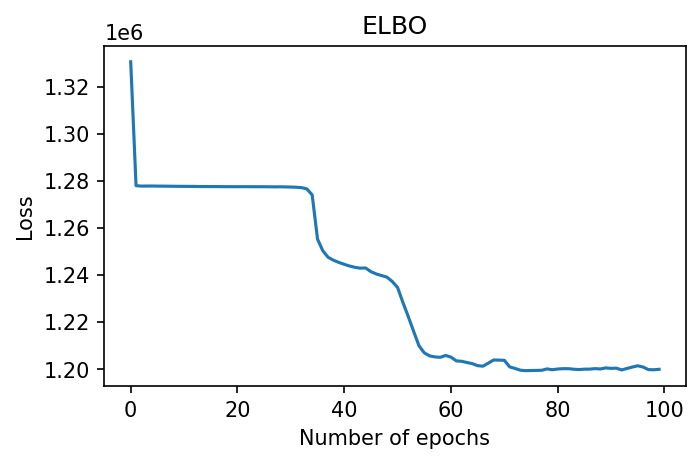

In [7]:
trained, gpvaeKCOVfour = train_model_fourier_gpvae(net, EPOCH = TOTAL_EPOCH, Fourier=FOURIER, visualize_ELBO=True, lr1=image_lr, loader_train=loader_train)

In [8]:
save_model(net, data = test_data_unbatched, Fourier= FOURIER, model_saved= gpvae_fourier_pruned_SAVE)

## GPVAE Fourier training

In [9]:
net= GPVAE( zimg_Dim=N_lats_img, Fourier = FOURIER, minlens =10)

Epoch 0 | Loss: 1277049.30
Epoch 50 | Loss: 1227545.49


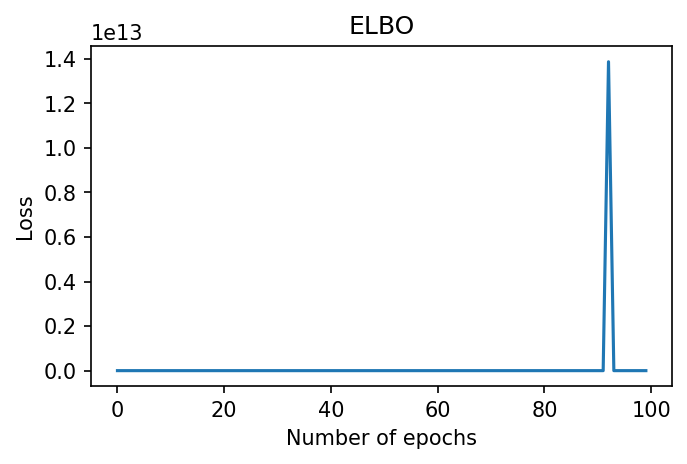

In [10]:
trained_unprune, gpvaeKCOVfour_unpruned = train_model_fourier_gpvae(net, EPOCH = TOTAL_EPOCH, Fourier=FOURIER, visualize_ELBO=True, lr1=image_lr, loader_train=loader_train,eps_v= 1e-1)

In [11]:
save_model(net, data = test_data_unbatched, Fourier= FOURIER, model_saved=gpvae_fourier_SAVE)

## VAE training

In [12]:
FOURIER = False

In [13]:
net= GPVAE(zimg_Dim=N_lats_img, Fourier = FOURIER,minlens =10)

Epoch 0 | Loss: 1266515.87
Epoch 50 | Loss: 1168156.69


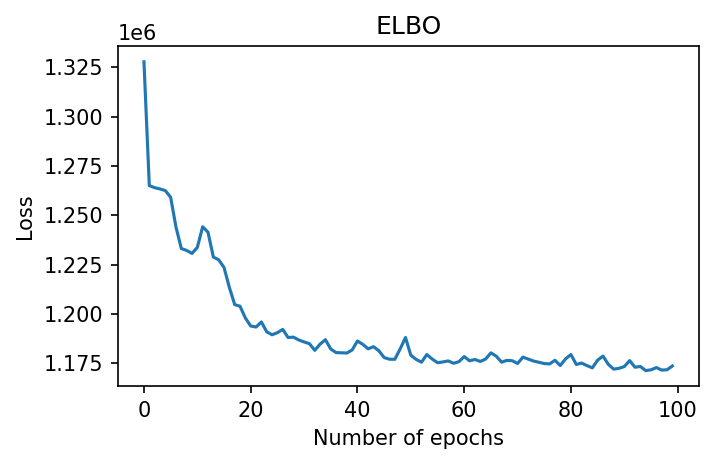

In [14]:
trained_gpvae = train_model_vae(net, EPOCH = TOTAL_EPOCH, Fourier=FOURIER, visualize_ELBO=True, lr1=image_lr, loader_train=loader_train)

In [15]:
save_model(net, data = test_data_unbatched, Fourier= FOURIER, model_saved= vae_SAVE)

## GPVAE training

In [16]:
net= GPVAE(zimg_Dim=N_lats_img, Fourier = FOURIER, minlens =10)

Epoch 0 | Loss: 6362521.33
Epoch 50 | Loss: 5872091.99


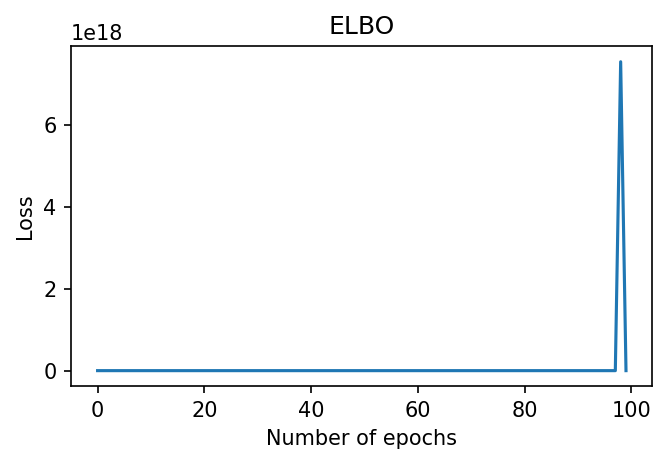

In [17]:
trained_time_gpvae, gpvaeKCOVtime = train_model_fourier_gpvae(net, EPOCH = TOTAL_EPOCH, Fourier=FOURIER, visualize_ELBO=True, lr1=image_lr, loader_train=loader_train)

In [18]:
save_model(net, data = test_data_unbatched, Fourier= FOURIER, model_saved=gpvae_SAVE)

## Evaluations

In [19]:
TIME_POINTS = 40
BATCH = 60
trial = 12
count = 500

In [20]:
time_vae = np.load(f'{vae_SAVE}.npy',
               allow_pickle=True)

zm_time_vae = np.squeeze(time_vae.item()['image_z'])
angle_time_vae = np.squeeze(time_vae.item()['angle'])
xhat_time_vae = np.squeeze(time_vae.item()['xhat'])
x_time_vae = np.squeeze(time_vae.item()['images'])

time_gpvae = np.load(f'{gpvae_SAVE}.npy',
               allow_pickle=True)

zm_time_gpvae = np.squeeze(time_gpvae.item()['image_z'])
angle_time_gpvae = np.squeeze(time_gpvae.item()['angle'])
xhat_time_gpvae = np.squeeze(time_gpvae.item()['xhat'])
x_time_gpvae = np.squeeze(time_gpvae.item()['images'])

fourier_gpvae = np.load(f'{gpvae_fourier_pruned_SAVE}.npy',
               allow_pickle=True)


zm_fourier_gpvae = np.squeeze(fourier_gpvae.item()['image_z'])
angle_fourier_gpvae = np.squeeze(fourier_gpvae.item()['angle'])
xhat_fourier_gpvae = np.squeeze(fourier_gpvae.item()['xhat'])
x_fourier_gpvae = np.squeeze(fourier_gpvae.item()['images'])


fourier_unpruned = np.load(f'{gpvae_fourier_SAVE}.npy',
               allow_pickle=True)

zm_fourier_unpruned = np.squeeze(fourier_unpruned.item()['image_z'])
angle_fourier_unpruned = np.squeeze(fourier_unpruned.item()['angle'])
xhat_fourier_unpruned = np.squeeze(fourier_unpruned.item()['xhat'])
x_fourier_unpruned = np.squeeze(fourier_unpruned.item()['images'])

In [21]:
def regress_anything(estimated, trueval):

    regr_end_angle = []

    z = trueval.squeeze()

    recon_z_const = np.stack((estimated.squeeze(), np.ones(np.shape(trueval.squeeze()))))

    regr_end_angle2 = []
    W = np.linalg.lstsq(recon_z_const.T, z.T)[0]

    regr_end_angle2.append((W.T@(recon_z_const)).T)

    regr_end_angle.append(np.array(regr_end_angle2))

    regr_end_angle = np.array(regr_end_angle)
    
    return regr_end_angle

In [22]:
angle_time_vae = np.concatenate(angle_time_vae, axis=0)
angle_time_gpvae = np.concatenate(angle_time_gpvae, axis=0)
angle_fourier_gpvae = np.concatenate(angle_fourier_gpvae, axis=0)
angle_fourier_unpruned = np.concatenate(angle_fourier_unpruned, axis=0)

zm_time_gpvae = np.concatenate(zm_time_gpvae, axis=0)
zm_time_vae = np.concatenate(zm_time_vae, axis=0)
zm_fourier_gpvae = np.concatenate(zm_fourier_gpvae, axis=0)
zm_fourier_unpruned= np.concatenate(zm_fourier_unpruned, axis=0)


In [23]:
gpvae_shared_regression_FOUR = regress_anything(zm_fourier_gpvae,angle_fourier_gpvae)
gpvae_shared_regression_FOUR_noprune = regress_anything(zm_fourier_unpruned,angle_fourier_unpruned)
gpvae_shared_regression_TIME = regress_anything(zm_time_gpvae,angle_time_gpvae)
vae_shared_regression_TIME = regress_anything(zm_time_vae, angle_time_vae)

gpvae_shared_regression_FOUR_noprune = np.reshape(gpvae_shared_regression_FOUR_noprune, (BATCH, TIME_POINTS, 1))
gpvae_shared_regression_FOUR = np.reshape(gpvae_shared_regression_FOUR, (BATCH, TIME_POINTS, 1))
gpvae_shared_regression_TIME = np.reshape(gpvae_shared_regression_TIME, (BATCH, TIME_POINTS, 1))
vae_shared_regression_TIME = np.reshape(vae_shared_regression_TIME, (BATCH, TIME_POINTS, 1))
angle_time_gpvae = np.reshape(angle_time_gpvae, (BATCH, TIME_POINTS, 1))
angle_fourier_gpvae = np.reshape(angle_fourier_gpvae, (BATCH, TIME_POINTS, 1))
angle_time_vae = np.reshape(angle_time_vae, (BATCH, TIME_POINTS, 1))
angle_fourier_unpruned =np.reshape(angle_fourier_unpruned, (BATCH, TIME_POINTS, 1))

/var/folders/zj/t98zryp54gq7l4jzwy8sc5xm0000gn/T/ipykernel_21359/1241457228.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W = np.linalg.lstsq(recon_z_const.T, z.T)[0]


In [24]:
print('----------------------------------------------------------------')
print('Loss in testing data for zm (shared) ')

shared_errors_fourier_gpvae = (np.mean((gpvae_shared_regression_FOUR- angle_fourier_gpvae)**2, axis = 1))
shared_errors_time_gpvae = (np.mean((gpvae_shared_regression_TIME  - angle_time_gpvae)**2, axis = 1))
shared_errors_time_vae = (np.mean((vae_shared_regression_TIME  - angle_fourier_gpvae )**2, axis = 1))
shared_errors_unprune = (np.mean((gpvae_shared_regression_FOUR_noprune  -angle_fourier_unpruned)**2, axis = 1))
print(f'The mean squared difference for fourier gpvae: {np.mean(shared_errors_fourier_gpvae)} \n')
print(f'The mean squared difference for time gpvae: {np.mean(shared_errors_time_gpvae)} \n')
print(f'The mean squared difference for time vae: {np.mean(shared_errors_time_vae)} \n')
print(f'The mean squared difference for fourier no pruning: {np.mean(shared_errors_unprune)} \n')

print('----------------------------------------------------------------')

----------------------------------------------------------------
Loss in testing data for zm (shared) 
The mean squared difference for fourier gpvae: 195.80219873542558 

The mean squared difference for time gpvae: 3806.59090554429 

The mean squared difference for time vae: 3811.643694721218 

The mean squared difference for fourier no pruning: 2891.282275244283 

----------------------------------------------------------------


([], [])

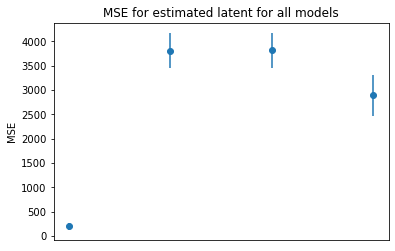

In [25]:
fig7 = plt.figure()
plt.errorbar(np.arange(4), [np.mean(shared_errors_fourier_gpvae), np.mean(shared_errors_time_gpvae),np.mean(shared_errors_time_vae),
                            np.mean(shared_errors_unprune) ],
yerr = [np.std(shared_errors_fourier_gpvae)/np.sqrt(60), np.std(shared_errors_time_gpvae)/np.sqrt(60), np.std(shared_errors_time_vae)/np.sqrt(60),
        np.std(shared_errors_unprune)/np.sqrt(60)],fmt= 'o')

plt.title('MSE for estimated latent for all models')
plt.ylabel('MSE')
plt.xticks([]) 


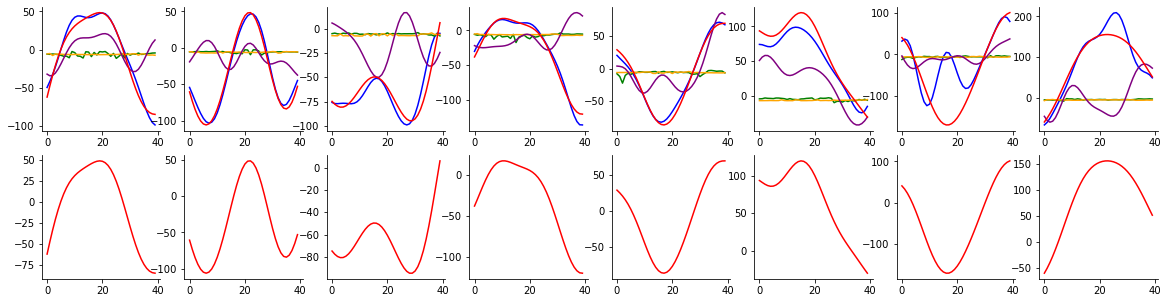

In [26]:
z = 8
trial =7 
fig4, axs = plt.subplots(2, z)
fig4.set_figheight(5)
fig4.set_figwidth(20)

for i in range(z):
    axs[0, i].plot(gpvae_shared_regression_FOUR[trial+i, :, :], color='blue', label='gpvae_fourier')
    axs[0, i].plot(gpvae_shared_regression_TIME[trial+i, :, :], color='green', label='gpvae_time')
    axs[0, i].plot(vae_shared_regression_TIME[trial+i, :, :], color='orange', label='var')
    axs[0, i].plot(gpvae_shared_regression_FOUR_noprune[trial+i, :, :], color='purple', label='gpvae_noprune')
    axs[0, i].plot(angle_time_gpvae[trial+i, :, :], color='red', label='true')

  
    axs[1, i].plot(angle_time_gpvae[trial+i, :, :], color='red', label='true')

 
    axs[0,i].spines['right'].set_visible(False)
    axs[0,i].spines['top'].set_visible(False)

    axs[1,i].spines['right'].set_visible(False)
    axs[1,i].spines['top'].set_visible(False)
   

In [27]:
x_four_gpvae = np.concatenate(x_fourier_gpvae, axis=0)
x_fourier_unpruned = np.concatenate(x_fourier_unpruned, axis=0)
x_time_gpvae= np.concatenate(x_time_gpvae, axis=0)
x_time_vae= np.concatenate(x_time_vae, axis=0)

xhat_four_gpvae = np.concatenate(xhat_fourier_gpvae, axis=0)
xhat_fourier_unpruned = np.concatenate(xhat_fourier_unpruned, axis=0)
xhat_time_gpvae= np.concatenate(xhat_time_gpvae, axis=0)
xhat_time_vae= np.concatenate(xhat_time_vae, axis=0)

In [28]:
xhat_four_gpvae = np.reshape(xhat_four_gpvae, (BATCH, TIME_POINTS, 36*36))
xhat_fourier_unpruned = np.reshape(xhat_fourier_unpruned, (BATCH, TIME_POINTS, 36*36))
xhat_time_gpvae = np.reshape(xhat_time_gpvae, (BATCH, TIME_POINTS, 36*36))
xhat_time_vae = np.reshape(xhat_time_vae, (BATCH, TIME_POINTS, 36*36))
x_time_vae = np.reshape(x_time_vae, (BATCH, TIME_POINTS, 36*36))
x_time_gpvae = np.reshape(x_time_gpvae, (BATCH, TIME_POINTS, 36*36))
x_four_gpvae = np.reshape(x_four_gpvae, (BATCH, TIME_POINTS, 36*36))
x_fourier_unpruned= np.reshape(x_fourier_unpruned, (BATCH, TIME_POINTS, 36*36))

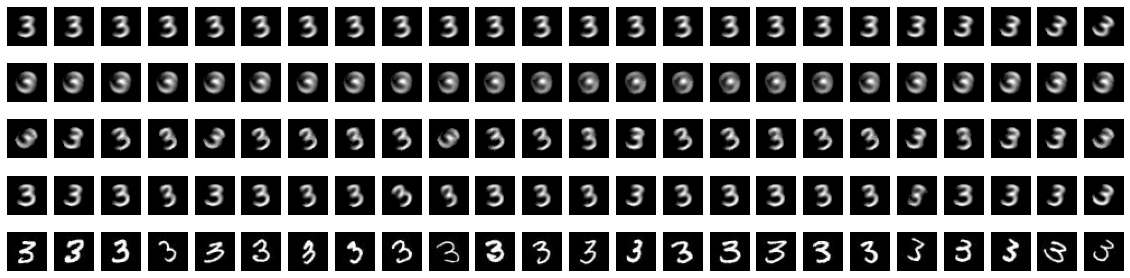

In [29]:
n = 24 
fig8, axs = plt.subplots(5, n)
fig8.set_figheight(5)
fig8.set_figwidth(20)
trial = 10
for i in range(n):

    axs[0,i].imshow(xhat_four_gpvae[trial][i+5].reshape(36,36), cmap = 'gray')
    axs[1,i].imshow(xhat_fourier_unpruned[trial][i+5].reshape(36,36), cmap = 'gray')
    axs[2,i].imshow(xhat_time_gpvae[trial][i+5].reshape(36,36), cmap = 'gray')
    axs[3,i].imshow(xhat_time_vae[trial][i+5].reshape(36,36), cmap = 'gray')
    axs[4,i].imshow(x_time_vae[trial][i+5].reshape(36,36), cmap = 'gray')

    axs[0,i].axis('off')
    axs[1,i].axis('off')
    axs[2,i].axis('off')
    axs[3,i].axis('off')
    axs[4,i].axis('off')
